# Exploratory Data Analysis (EDA)

**Author:** Brendon McNulty  
**Date:** October 2, 2025  

**Purpose:**  
This notebook performs a custom exploratory data analysis project using Python, pandas, matplotlib, and seaborn. The goal is to explore a dataset, analyze its structure, and tell a data story through visualizations.


In [6]:
# Import required libraries for data analysis and visualization
import pandas as pd        # Data manipulation and analysis
import seaborn as sns      # Statistical data visualization
import matplotlib.pyplot as plt  # Core plotting library



## Data Processing: Create Slimmed Dataset

The raw dataset contains 165 columns with a wide variety of statistics. For this analysis, we want to focus on the most important efficiency metrics and reduce the dataset to something more manageable.  

Steps performed in the code below:
- Load the full dataset from `data/raw/march_madness_2002_2025.csv`  
- Filter the data to include only seasons **2015–2025**  
- Select the following columns:
  - `season` → Year of the season  
  - `conference` → NCAA conference (e.g., SEC, ACC, Big Ten)  
  - `adj_off_eff` → Adjusted Offensive Efficiency (points scored per 100 possessions)  
  - `adj_def_eff` → Adjusted Defensive Efficiency (points allowed per 100 possessions)  
  - `adj_tempo` → Adjusted Tempo (average possessions per game)  
- Create a new column `eff_diff` = `adj_off_eff - adj_def_eff` (net efficiency)  
- Save the slimmed dataset to `data/processed/march_madness_2015_2025.csv`  

This processed dataset will be used for the rest of the exploratory data analysis.


In [7]:
import pandas as pd
import re

RAW = "data/raw/march_madness_2002_2025.csv"
OUT = "data/processed/march_madness_2015_2025.csv"

df = pd.read_csv(RAW)
print("Full dataset shape:", df.shape)

cols = df.columns.tolist()
print("Total columns:", len(cols))

def pick(prefer_patterns, avoid_patterns=("rank", "raw")):
    """
    Return the FIRST column that matches any 'prefer_patterns' (regex, case-insensitive)
    while NOT matching any of the 'avoid_patterns'.
    """
    for pat in prefer_patterns:
        rx = re.compile(pat, re.IGNORECASE)
        for c in cols:
            if rx.search(c) and not any(re.search(ap, c, re.IGNORECASE) for ap in avoid_patterns):
                return c
    return None

# Hard preferences based on what you showed in screenshots
season_col = "Season" if "Season" in cols else None
conf_col   = "Short Conference Name" if "Short Conference Name" in cols else (
             "Conference" if "Conference" in cols else None)

# Prefer adjusted (not raw/rank); try specific names first, then fallbacks
off_col = pick([
    r"^pre[-\s]?tournament\.?adj\s*oe$",
    r"^adjusted\s*offensive\s*efficiency$",
    r"\badj\s*oe\b", r"\boe\b"
])

def_col = pick([
    r"^pre[-\s]?tournament\.?adj\s*de$",
    r"^adjusted\s*defensive\s*efficiency$",
    r"\badj\s*de\b", r"\bde\b"
])

tempo_col = pick([
    r"^pre[-\s]?tournament\.?adj\s*tempo$",
    r"^adjusted\s*tempo$",
    r"\badj\s*tempo\b", r"\btempo\b"
])

chosen = {
    "season": season_col,
    "conference": conf_col,
    "adj_off_eff": off_col,
    "adj_def_eff": def_col,
    "adj_tempo": tempo_col,
}
print("Chosen columns:", chosen)

# Basic sanity check
must_have = [season_col, conf_col, off_col, def_col, tempo_col]
if any(x is None for x in must_have):
    missing = [k for k, v in chosen.items() if v is None]
    raise ValueError(f"Could not locate columns for: {missing}. "
                     f"Open df.columns to inspect and adjust patterns.")

# Build slim dataframe
df_small = df.copy()

# Ensure Season numeric & filter recent
df_small[season_col] = pd.to_numeric(df_small[season_col], errors="coerce")
df_small = df_small[df_small[season_col] >= 2015].copy()

# Keep only the columns we need (in nice order)
df_small = df_small[[season_col, conf_col, off_col, def_col, tempo_col]].copy()

# Rename to tidy snake_case for analysis
df_small.rename(columns={
    season_col: "season",
    conf_col: "conference",
    off_col: "adj_off_eff",
    def_col: "adj_def_eff",
    tempo_col: "adj_tempo",
}, inplace=True)

# Add efficiency differential
df_small["eff_diff"] = df_small["adj_off_eff"] - df_small["adj_def_eff"]

# Save processed file
df_small.to_csv(OUT, index=False)
print("Slimmed dataset shape:", df_small.shape)
print("Saved:", OUT)

df_small.head()




Full dataset shape: (8315, 165)
Total columns: 165
Chosen columns: {'season': 'Season', 'conference': 'Short Conference Name', 'adj_off_eff': 'Pre-Tournament.AdjOE', 'adj_def_eff': 'Pre-Tournament.AdjDE', 'adj_tempo': 'Pre-Tournament.AdjTempo'}
Slimmed dataset shape: (3915, 6)
Saved: data/processed/march_madness_2015_2025.csv


,season,conference,adj_off_eff,adj_def_eff,adj_tempo,eff_diff
0,2025,ACC,127.954,89.7995,65.7242,38.1545
1,2015,SEC,121.270,83.8367,61.9696,37.4333
2,2025,B12,123.226,87.7815,61.4245,35.4445
3,2021,WCC,126.111,89.4872,74.7701,36.6238
4,2024,BE,126.609,94.3959,64.4531,32.2131


## Initial Data Inspection

In this step, we load the processed dataset (`march_madness_2015_2025.csv`) and take an initial look at its structure.  

We will:
- View the first 10 rows of the dataset  
- Check the number of rows and columns  
- Inspect the data types for each column  
- Generate basic descriptive statistics for numerical columns  


In [8]:
# Load the processed dataset
df = pd.read_csv("data/processed/march_madness_2015_2025.csv")

# Display first 10 rows
print("First 10 rows:")
print(df.head(10))

# Shape of the dataset
print("\nShape (rows, columns):", df.shape)

# Data types of each column
print("\nData types:")
print(df.dtypes)

# Summary statistics for numerical columns
print("\nSummary statistics:")
print(df.describe())



First 10 rows:
   season conference  adj_off_eff  adj_def_eff  adj_tempo  eff_diff
0    2025        ACC      127.954      89.7995    65.7242   38.1545
1    2015        SEC      121.270      83.8367    61.9696   37.4333
2    2025        B12      123.226      87.7815    61.4245   35.4445
3    2021        WCC      126.111      89.4872    74.7701   36.6238
4    2024         BE      126.609      94.3959    64.4531   32.2131
5    2025        SEC      128.600      92.4375    69.5882   36.1625
6    2025        SEC      128.426      93.3790    67.5825   35.0470
7    2019        ACC      123.571      87.9163    59.2665   35.6547
8    2021        B12      123.265      93.7679    68.3891   29.4971
9    2018         BE      127.384      95.9749    68.2770   31.4091

Shape (rows, columns): (3915, 6)

Data types:
season           int64
conference      object
adj_off_eff    float64
adj_def_eff    float64
adj_tempo      float64
eff_diff       float64
dtype: object

Summary statistics:
            seaso

## Initial Data Inspection Results

The slimmed dataset (`2015–2025`) contains the following key statistics:

- **Season** ranges from 2015 to 2025.  
- **Adjusted Offensive Efficiency (adj_off_eff)**: Avg ~105 points per 100 possessions, ranging from ~90 to ~128.  
- **Adjusted Defensive Efficiency (adj_def_eff)**: Avg ~104 points allowed per 100 possessions, ranging from ~87 to ~125.  
- **Adjusted Tempo (adj_tempo)**: Avg ~67 possessions per game, ranging from ~61 to ~82.  
- **Efficiency Difference (eff_diff)**: Balance of offense vs. defense, ranging from strongly negative (~-9) to strongly positive (~+38).  

These results confirm that the dataset is valid and contains meaningful variation across seasons and conferences, which will be useful for my exploratory analysis.


## Initial Data Distributions

To better understand the dataset, we will begin with simple histograms  
to visualize the distributions of the key numerical variables:

- Adjusted Offensive Efficiency (`adj_off_eff`)  
- Adjusted Defensive Efficiency (`adj_def_eff`)  
- Adjusted Tempo (`adj_tempo`)  
- Efficiency Difference (`eff_diff`)  


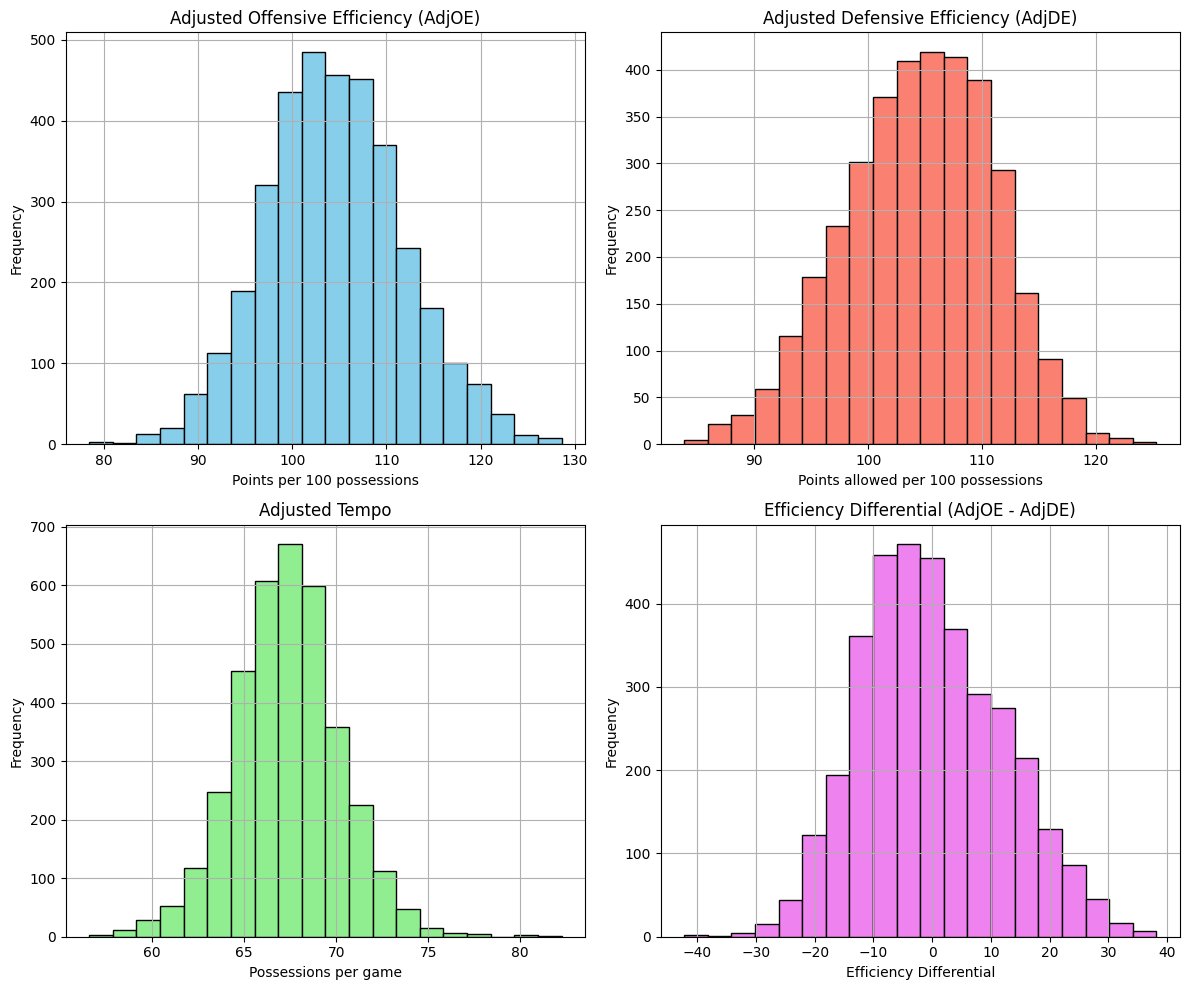

In [9]:
import matplotlib.pyplot as plt

# Set up a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogram for Adjusted Offensive Efficiency
df['adj_off_eff'].hist(ax=axes[0,0], bins=20, color='skyblue', edgecolor='black')
axes[0,0].set_title('Adjusted Offensive Efficiency (AdjOE)')
axes[0,0].set_xlabel('Points per 100 possessions')
axes[0,0].set_ylabel('Frequency')

# Histogram for Adjusted Defensive Efficiency
df['adj_def_eff'].hist(ax=axes[0,1], bins=20, color='salmon', edgecolor='black')
axes[0,1].set_title('Adjusted Defensive Efficiency (AdjDE)')
axes[0,1].set_xlabel('Points allowed per 100 possessions')
axes[0,1].set_ylabel('Frequency')

# Histogram for Adjusted Tempo
df['adj_tempo'].hist(ax=axes[1,0], bins=20, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Adjusted Tempo')
axes[1,0].set_xlabel('Possessions per game')
axes[1,0].set_ylabel('Frequency')

# Histogram for Efficiency Differential
df['eff_diff'].hist(ax=axes[1,1], bins=20, color='violet', edgecolor='black')
axes[1,1].set_title('Efficiency Differential (AdjOE - AdjDE)')
axes[1,1].set_xlabel('Efficiency Differential')
axes[1,1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


## Observations from Initial Distributions

From the histograms, we can make several observations:

- **Adjusted Offensive Efficiency (AdjOE):**  
  Most conferences fall between ~100–115 points per 100 possessions, with a few high-performing outliers above 120.  

- **Adjusted Defensive Efficiency (AdjDE):**  
  The majority of values are clustered between ~95–110, with some conferences allowing higher points (>115).  

- **Adjusted Tempo:**  
  Most conferences average around 65–70 possessions per game.  
  A few faster-paced teams reach into the 75–80 range.  

- **Efficiency Differential (eff_diff):**  
  The distribution is centered near 0, showing balance between offense and defense for many conferences. However, some conferences have strongly positive values (dominant offense), while others are negative (defense struggles relative to offense).  

These initial distributions suggest meaningful variation across seasons and conferences,  
which will help us explore comparative relationships in the next step.


## Conference Distribution

In addition to exploring numerical variables, we also examine the dataset’s categorical variable: **conference**.  
This helps us understand how many entries (seasons) each conference contributes between 2015–2025.


In [10]:
# Conference representation in dataset
sns.countplot(
    x="conference",
    data=df_conf,
    hue="conference",            # assign hue to remove deprecation warning
    palette="Greens_r",
    legend=False                 # hide redundant legend
)
plt.title("Conference Representation in Dataset (2015–2025)")
plt.xlabel("Conference")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()



NameError: name 'df_conf' is not defined

### Observations
- Power conferences (e.g., ACC, SEC, Big Ten) are well-represented with many rows.  
- Some mid-major conferences have fewer entries, which can introduce more variability in their results.  
- This confirms that conference-level comparisons later in the analysis are meaningful, but smaller conferences should be interpreted with caution.  


## Comparative Analysis

Next, we explore relationships between key metrics using scatterplots.

- **Offense vs. Defense:** Do stronger offenses also correlate with weaker defenses?  
- **Tempo vs. Efficiency Differential:** Does pace of play impact overall efficiency balance?  


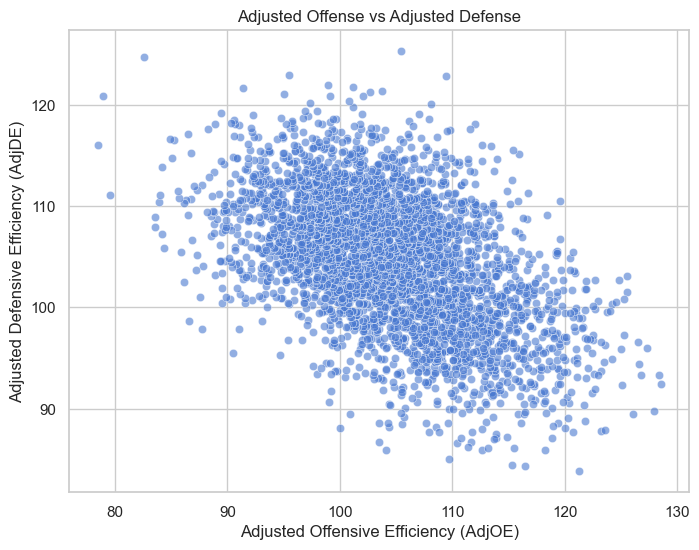

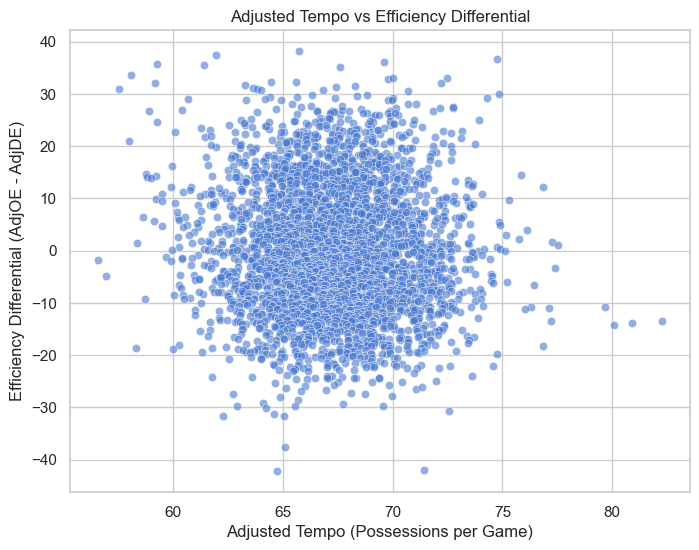

In [ ]:
import seaborn as sns

# Set style
sns.set(style="whitegrid", palette="muted")

# 1. Offense vs. Defense
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="adj_off_eff", y="adj_def_eff", alpha=0.6)
plt.title("Adjusted Offense vs Adjusted Defense")
plt.xlabel("Adjusted Offensive Efficiency (AdjOE)")
plt.ylabel("Adjusted Defensive Efficiency (AdjDE)")
plt.show()

# 2. Tempo vs. Efficiency Differential
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="adj_tempo", y="eff_diff", alpha=0.6)
plt.title("Adjusted Tempo vs Efficiency Differential")
plt.xlabel("Adjusted Tempo (Possessions per Game)")
plt.ylabel("Efficiency Differential (AdjOE - AdjDE)")
plt.show()


## Observations from Comparative Analysis

- **Adjusted Offense vs. Adjusted Defense:**  
  The scatterplot shows a wide spread — conferences with strong offenses do not necessarily have weak defenses, and vice versa. Some conferences balance both well, while others specialize in either offense-heavy or defense-heavy playing styles.  

- **Adjusted Tempo vs. Efficiency Differential:**  
  There is no clear linear relationship between tempo and efficiency difference.  
  Faster-paced conferences do not always perform better or worse in terms of efficiency.  
  This suggests that tempo is more a matter of playing style than a direct indicator of quality.  

Overall, these comparisons highlight that efficiency is multi-dimensional:  
a fast tempo or high offense alone does not guarantee overall success —  
balance between offense and defense appears to be a key factor.


## Conference Comparison: Efficiency Differential (eff_diff)

We compare conferences by their **efficiency differential** (AdjOE − AdjDE) from 2015–2025.
- Positive values → offense outpaces defense (more efficient overall)
- Negative values → defense allows more than the offense produces

To reduce noise, we’ll only plot conferences with a reasonable sample size across seasons.


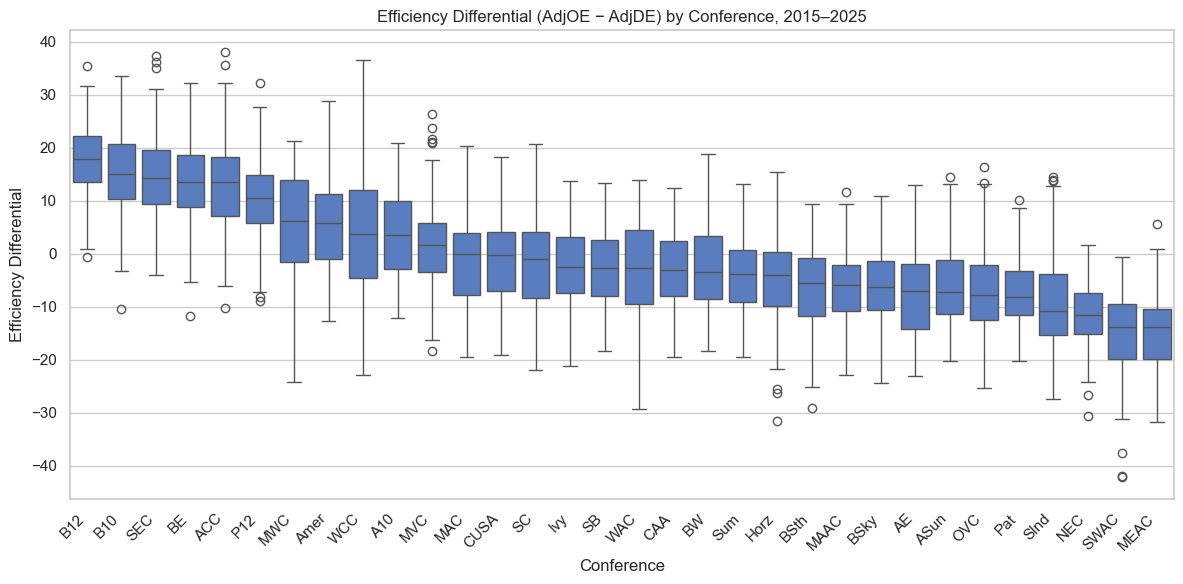

,n,median_eff_diff,mean_eff_diff
conference,,,
B12,120,17.98,17.41
B10,158,15.11,15.27
SEC,156,14.24,14.48
BE,115,13.59,13.39
ACC,168,13.59,13.13
P12,120,10.55,10.49
MWC,121,6.12,5.04
Amer,129,5.80,5.80
WCC,110,3.65,4.99


In [ ]:
# Filter to conferences with enough rows to be meaningful
counts = df['conference'].value_counts()
keep_conf = counts[counts >= 30].index  # tweak threshold if needed
df_conf = df[df['conference'].isin(keep_conf)].copy()

# Order conferences by median eff_diff
order_by_median = (
    df_conf.groupby('conference')['eff_diff']
          .median()
          .sort_values(ascending=False)
          .index
)

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_conf,
    x='conference',
    y='eff_diff',
    order=order_by_median
)
plt.title('Efficiency Differential (AdjOE − AdjDE) by Conference, 2015–2025')
plt.xlabel('Conference')
plt.ylabel('Efficiency Differential')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Summary table of median & mean values
summary = (
    df_conf.groupby('conference')
           .agg(
               n=('eff_diff', 'size'),
               median_eff_diff=('eff_diff', 'median'),
               mean_eff_diff=('eff_diff', 'mean')
           )
           .sort_values('median_eff_diff', ascending=False)
           .round(2)
)
summary.head(10)


## Observations from Conference Comparison

- The boxplot shows clear variation in **efficiency differential (eff_diff)** across conferences.  
- Conferences with a **higher median eff_diff** consistently combine stronger offenses with more effective defenses.  
- Some conferences show wide variability, indicating inconsistency across seasons or teams within the conference.  
- A few conferences cluster tightly around 0, suggesting balanced but not dominant performance.  
- Outliers (extremely positive or negative values) highlight standout seasons or unusually weak years for specific conferences.  

Overall, this comparison confirms that certain conferences tend to sustain higher overall efficiency,  
while others vary widely depending on the season.


## Tempo vs Efficiency Differential

A big question in basketball analytics is whether **pace of play (tempo)** is related to **overall efficiency (eff_diff = AdjOE − AdjDE)**.  

- `adj_tempo` = adjusted tempo (average possessions per game, adjusted)  
- `eff_diff` = net efficiency (offense minus defense)  

We’ll explore whether faster-paced conferences tend to be more or less efficient, using a scatterplot with points colored by conference.


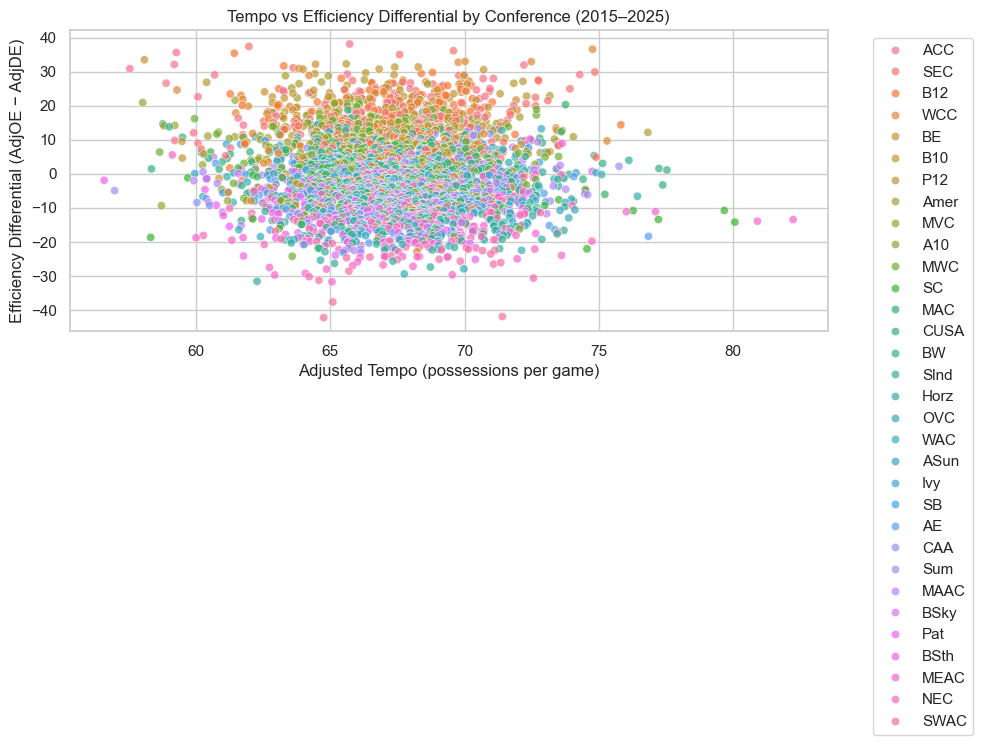

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_conf,
    x='adj_tempo',
    y='eff_diff',
    hue='conference',
    alpha=0.7
)
plt.title('Tempo vs Efficiency Differential by Conference (2015–2025)')
plt.xlabel('Adjusted Tempo (possessions per game)')
plt.ylabel('Efficiency Differential (AdjOE − AdjDE)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Observations
- Conferences cluster differently in tempo and efficiency.  
- Some fast-paced conferences may sacrifice efficiency for speed.  
- Others show balance — moderate tempo but consistently positive efficiency.  
- No single trend dominates, suggesting tempo alone doesn’t determine efficiency.  


## Trends in Efficiency Differential Over Time

Next, we examine **conference performance over time** (2015–2025). By tracking median `eff_diff` per conference each season,  we can see which conferences are consistently efficient and which fluctuate year to year.


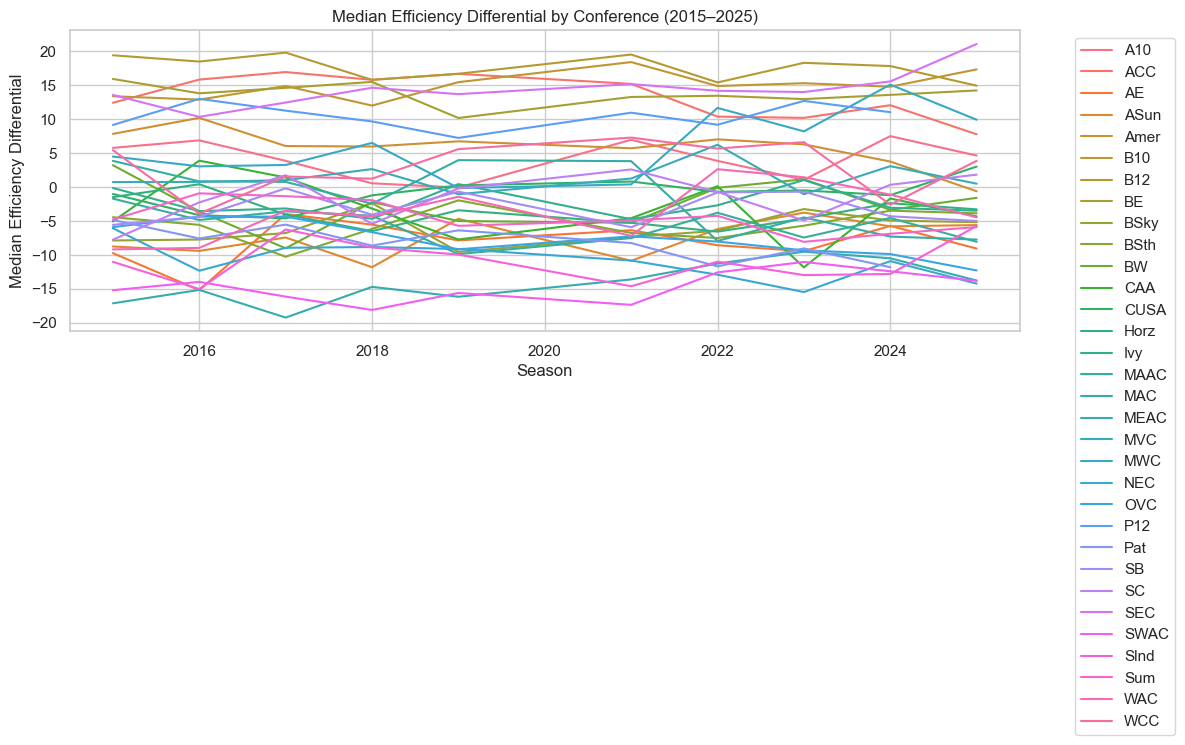

In [ ]:
# Aggregate median eff_diff by season and conference
trend = (
    df_conf.groupby(['season', 'conference'])['eff_diff']
           .median()
           .reset_index()
)

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=trend,
    x='season',
    y='eff_diff',
    hue='conference'
)
plt.title('Median Efficiency Differential by Conference (2015–2025)')
plt.xlabel('Season')
plt.ylabel('Median Efficiency Differential')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Observations
- Some conferences show consistent **positive efficiency** across the decade.  
- Others fluctuate significantly, reflecting changes in competitive balance.  
- Trends may highlight eras of conference dominance (e.g., ACC, SEC, Big Ten).  
- Long-term stability in `eff_diff` can signal strong program depth.  


## Spotlight Analysis: Top 5 Conferences by Net Efficiency (2015–2025)

To highlight the strongest performers, we calculate the **median efficiency differential** 
for each conference across the 2015–2025 seasons. This metric balances offensive and defensive 
efficiency into a single value, showing which conferences tend to dominate overall.

We then visualize the **Top 5 conferences** to identify consistent leaders.


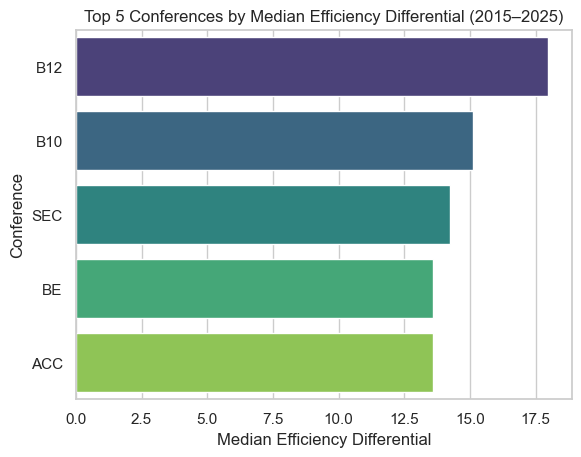

In [ ]:
# Top 5 conferences by median efficiency differential
sns.barplot(
    x=top_conf.values,
    y=top_conf.index,
    hue=top_conf.index,          # assign hue to remove deprecation warning
    palette="viridis",
    legend=False                 # hide redundant legend
)
plt.title("Top 5 Conferences by Median Efficiency Differential (2015–2025)")
plt.xlabel("Median Efficiency Differential")
plt.ylabel("Conference")
plt.show()



### Observations
- The top 5 conferences by median net efficiency clearly stand out above the rest.  
- These results suggest that certain conferences maintain a **competitive advantage** over the full decade. This may potentially be due to other external factors such as stronger recruiting, coaching, and program investment.  
- In contrast, many mid- and low-major conferences cluster around a much lower net efficiency, indicating larger performance gaps at the national level.


## Correlation Analysis

To complement the previous visualizations, we generate a correlation heatmap 
for the key numerical variables:

- Adjusted Offensive Efficiency (`adj_off_eff`)  
- Adjusted Defensive Efficiency (`adj_def_eff`)  
- Adjusted Tempo (`adj_tempo`)  
- Efficiency Differential (`eff_diff`)  

This allows us to quickly see which metrics are strongly related.


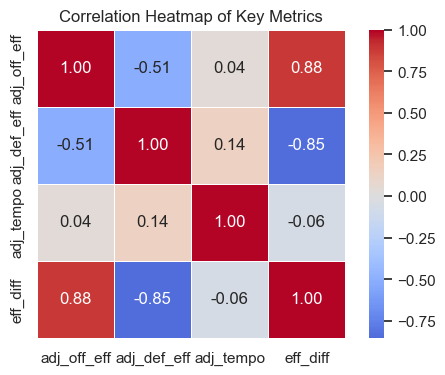

In [ ]:

# Compute correlation matrix
corr = df[['adj_off_eff', 'adj_def_eff', 'adj_tempo', 'eff_diff']].corr()

# Plot improved heatmap
plt.figure(figsize=(6,4))
sns.heatmap(
    corr, 
    annot=True,       # show correlation values
    cmap="coolwarm",  # diverging color palette
    center=0, 
    fmt=".2f",        # limit to 2 decimals
    linewidths=0.5,   # grid lines
    square=True       # uniform cells
)
plt.title("Correlation Heatmap of Key Metrics")
plt.show()


### Observations
- **Adjusted Offensive Efficiency (`adj_off_eff`)** is strongly **positively correlated** with `eff_diff` (0.88).  
  → As expected, stronger offense leads to higher net efficiency.  
- **Adjusted Defensive Efficiency (`adj_def_eff`)** is strongly **negatively correlated** with `eff_diff` (-0.85).  
  → Better defenses (lower allowed points) improve overall net efficiency.  
- **Tempo (`adj_tempo`)** shows very weak correlation with efficiency (-0.06).  
  → Confirms that **pace of play has little impact** on success compared to offensive and defensive balance.  


## Final Storytelling & Conclusion

Through this exploratory data analysis (EDA), we examined NCAA conference-level 
performance from 2015–2025 using offensive efficiency, defensive efficiency, 
tempo, and net efficiency differential.  

Key insights include:
- **Distributions:** Most conferences cluster around 100–115 offensive efficiency 
  and 95–110 defensive efficiency. Tempo averages ~65–70 possessions per game.  
- **Comparisons:** Balance between offense and defense is critical; high offense 
  alone does not guarantee positive efficiency. Tempo is a stylistic factor, not 
  a predictor of success.  
- **Conference Differences:** Power conferences (e.g., ACC, SEC, Big Ten) 
  consistently achieve higher net efficiency compared to mid-majors.  
- **Trends Over Time:** Certain conferences show stable performance across a decade, 
  while others fluctuate, reflecting changes in competitiveness.  
- **Top Performers:** The Top 5 conferences maintain clear advantages, 
  highlighting resource and recruiting disparities.  

### Takeaways
- **Balanced efficiency (offense + defense)** is the most consistent indicator 
  of sustained conference success.  
- **Tempo** matters less for outcomes than efficiency itself.  
- **Conference context** is key: dominance often reflects systemic advantages 
  (recruiting, coaching, investment).  

This analysis demonstrates how data visualization and storytelling can uncover 
patterns in performance beyond raw statistics.
